# Wind Turbine Power Generation Forecasting

Train dataset contains hourly meteorological data along with power output measurements collected between January 2013 and December 2016. The data includes variables such as temperature, relative humidity, wind speed at various altitudes, and power generated at different locations.

## Prepare workspace

1. Import dependencies.

In [1]:
import numpy as np
import pandas as pd
import sklearn

from lib.ml.layer.layer_def import Dense, Input
from lib.ml.util.loss_function import MEAN_SQUARED_ERROR
from lib.ml.model.seq_model import SeqNet, ValidationData
from lib.ml.optimizer.genetic_optimizer import GeneticOptimizer
from lib.ml.optimizer.gradient_descent_optimizer import GradientDescentOptimizer
from lib.ml.util.progress_tracker import NotebookProgressTracker
from lib.ml.util.lr_scheduler import ReduceLROnPlateau

from lib.ml.util.activation_function import RELU_ACTIVATION
from src.data.wind_turbine.wind_turbine_dataset import (
    download_wind_turbine_dataset,
    process_wind_turbine_dataset,
    split_turbine_dataset,
    window_and_split_turbine_dataset
)
from src.definitions import EXTERNAL_DATA_FOLDER
from src.visualization.plot import plot_loss_and_val_loss, plot_diff

from sklearn.discriminant_analysis import StandardScaler

2. Download and process `sudhanvahg/wind-turbine-power-generation-forecasting` dataset.

In [2]:
archive = download_wind_turbine_dataset(EXTERNAL_DATA_FOLDER)

3. Split on train/test/validate. Extract free and bound variables. Scale input.

In [3]:
scaler = StandardScaler()

dataset = process_wind_turbine_dataset(
    archive,
    scaler=scaler,
)

dataset.head(5)

,Temp_2m,RelHum_2m,DP_2m,WS_10m,WS_100m,WD_10m,WD_100m,WG_10m,Power
0,-0.804021,0.837857,-0.562194,-1.355386,-1.850563,-0.555885,-0.391588,-1.845008,0.151429
1,-0.808581,0.896680,-0.552661,-1.049536,-0.957421,-0.505925,-0.431150,-1.017793,0.133128
2,-0.881539,1.190795,-0.562194,-1.424449,-1.353283,-0.535901,-0.510276,-1.348679,0.114574
3,-0.854179,1.014326,-0.571727,-1.424449,-1.382727,-1.435186,-0.955355,-1.789861,0.095579
4,-0.858739,1.014326,-0.581260,-0.847281,-0.813472,-1.435186,-1.163059,-1.128089,0.076309


In [4]:
# x_train, y_train, x_valid, y_valid, x_test, y_test = window_and_split_turbine_dataset(
#     dataset=dataset, test_train_ratio=0.8, train_valid_ratio=0.9, window_size=10
# )

x_train, y_train, x_valid, y_valid, x_test, y_test = split_turbine_dataset(
    dataset=dataset, test_train_ratio=0.8, train_valid_ratio=0.9
)

print("x_train = " + str(x_train.shape))
print("y_train = " + str(y_train.shape))
print("x_valid = " + str(x_valid.shape))
print("y_valid = " + str(y_valid.shape))
print("x_test = " + str(x_test.shape))
print("y_test = " + str(y_test.shape))

validation_data = ValidationData(x_valid, y_valid)

x_train = (8, 100915)
y_train = (1, 100915)
x_valid = (8, 11213)
y_valid = (1, 11213)
x_test = (8, 28032)
y_test = (1, 28032)


## Train NN using genetic optimizer

1. Define neural network.

In [5]:
model = SeqNet(
    layers=[
        Input(x_train.shape[0]),
        Dense(64, activation_fun=RELU_ACTIVATION),
        Dense(1),
    ]
)

opt = GeneticOptimizer(
    population_size=200, mutation_rate=0.5, mutation_decay=0.005
)

compiled_model = model.compile(
    optimizer=opt,
    loss=MEAN_SQUARED_ERROR,
    progress_tracker=NotebookProgressTracker(),
)

2. Train neural network.

Progress:   0%|          | 0/300 [00:00<?, ?it/s]

loss = 0.04333329351293772


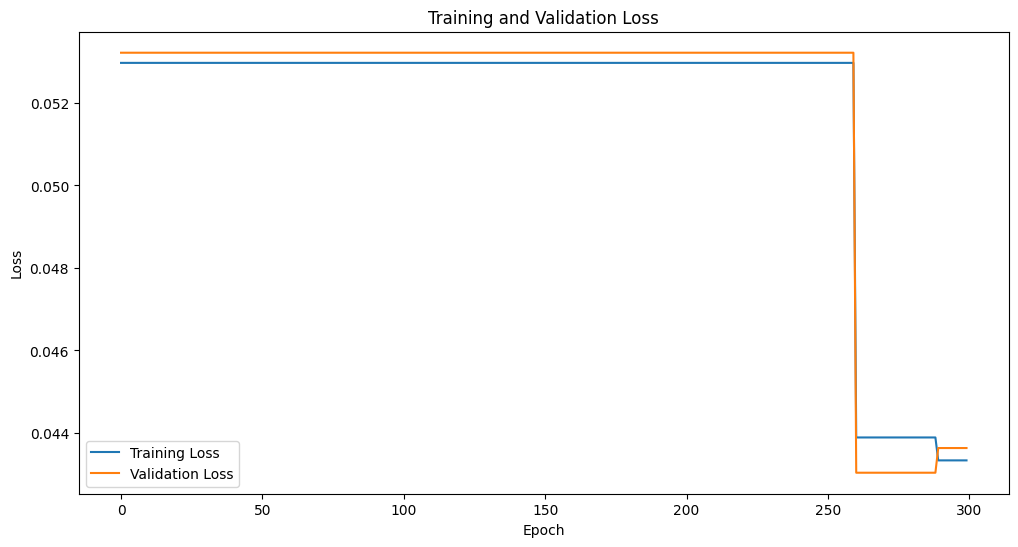

In [6]:
trained_model = compiled_model.fit(
    x_train, y_train, 300, validation_data=validation_data
)

print("loss = " + str(trained_model.train_loss()))

plot_loss_and_val_loss(trained_model)

3. Test neural network.

loss = 0.04337574266225064
R2 score = -0.26414570387368697


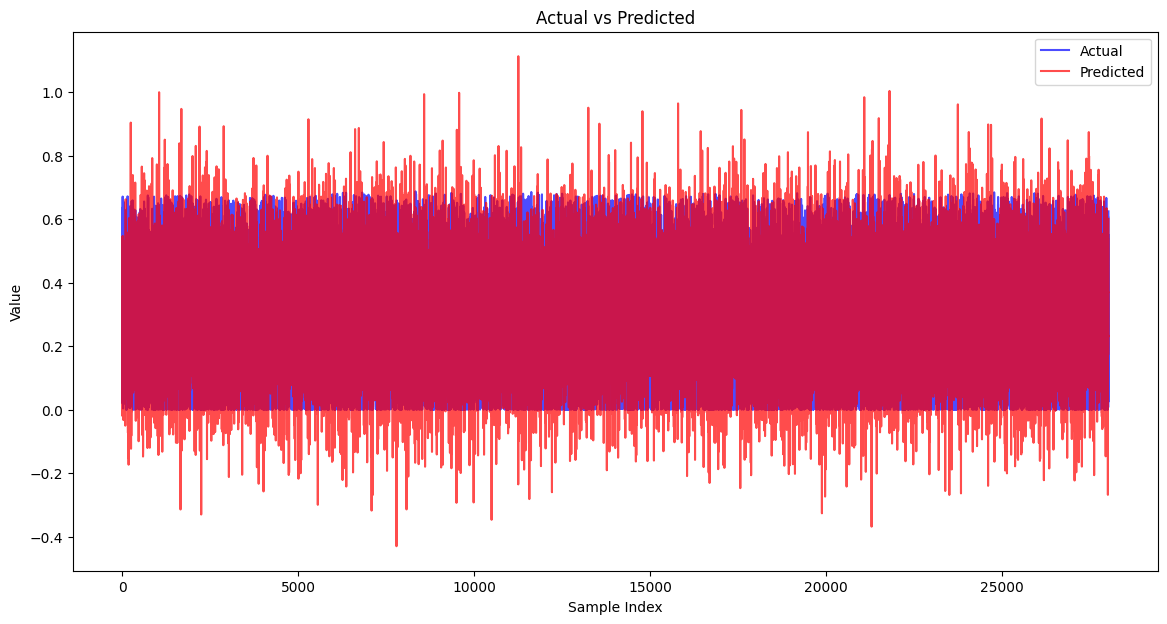

In [7]:
y_predicted = trained_model.predict(x_test)

print("loss = " + str(MEAN_SQUARED_ERROR.apply(y_test, y_predicted)))
print(
    "R2 score = "
    + str(sklearn.metrics.r2_score(y_test.flatten(), y_predicted.flatten()))
)

plot_diff(y_test.flatten(), y_predicted.flatten())

4. Build report

In [8]:
delta = y_test - y_predicted

report = pd.DataFrame(
    {
        "Power RO": y_test.flatten(),
        "Power PO": y_predicted.flatten(),
        "DELTA": delta.flatten(),
        "DELTA^2": np.square(delta.flatten()),
    }
)

report_head = report.head(12)

display(report_head)

print("Delta total = " + str(report_head["DELTA"].sum()))
print("Delta^2 total = " + str(report_head["DELTA^2"].sum()))

,Power RO,Power PO,DELTA,DELTA^2
0,0.133740,0.226582,-0.092842,0.008620
1,0.031592,-0.019102,0.050694,0.002570
2,0.406129,0.290460,0.115669,0.013379
3,0.313201,0.226694,0.086507,0.007483
4,0.264973,0.108222,0.156751,0.024571
5,0.219935,0.355416,-0.135481,0.018355
6,0.112432,0.055716,0.056715,0.003217
7,0.196303,0.493836,-0.297533,0.088526
8,0.363250,0.439394,-0.076143,0.005798
9,0.019799,0.063972,-0.044174,0.001951


Delta total = -0.4844550470287378
Delta^2 total = 0.3433117283923401


## Train NN using gradient descent optimizer

1. Define Neural network

In [5]:
model = SeqNet(
    layers=[
        Input(x_train.shape[0]),
        Dense(1024, activation_fun=RELU_ACTIVATION),
        Dense(1024, activation_fun=RELU_ACTIVATION),
        Dense(512, activation_fun=RELU_ACTIVATION),
        Dense(1),
    ]
)

lr_scheduler = ReduceLROnPlateau(lr=1e-3, patience=5, factor=0.1, min_lr=1e-6)
opt = GradientDescentOptimizer(lr_scheduler=lr_scheduler, momentum_decay=0.9)

compiled_model = model.compile(
    optimizer=opt,
    loss=MEAN_SQUARED_ERROR,
    lr_scheduler=lr_scheduler,
    progress_tracker=NotebookProgressTracker(),
)

2. Train neural network.

Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

loss = 0.03253623239961948


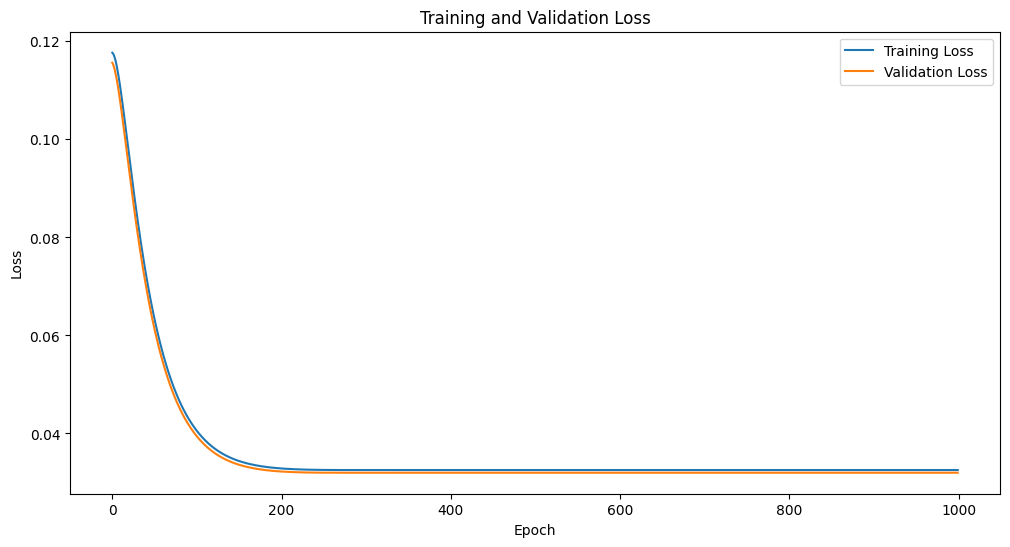

In [6]:
trained_model = compiled_model.fit(
    x_train, y_train, 1000, validation_data=validation_data
)

print("loss = " + str(trained_model.train_loss()))

plot_loss_and_val_loss(trained_model)

3. Test neural network.

loss = 0.03267305277276008
R2 score = 0.04978626121583163


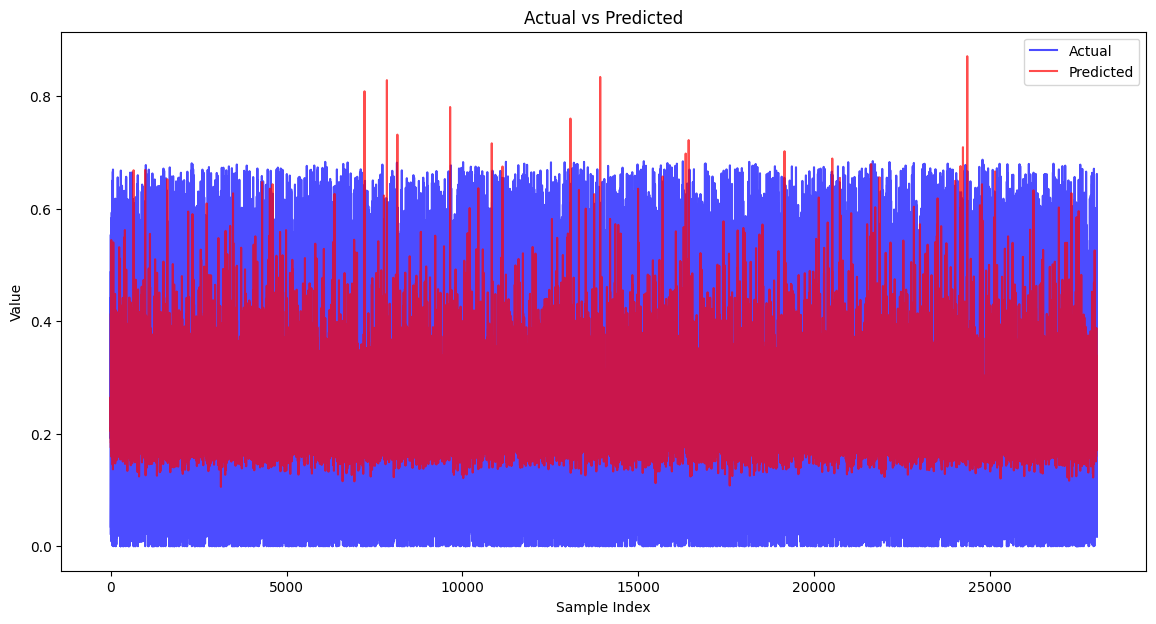

In [7]:
y_predicted = trained_model.predict(x_test)

print("loss = " + str(MEAN_SQUARED_ERROR.apply(y_test, y_predicted)))
print(
    "R2 score = "
    + str(sklearn.metrics.r2_score(y_test.flatten(), y_predicted.flatten()))
)

plot_diff(y_test.flatten(), y_predicted.flatten())

4. Build report

In [8]:
delta = y_test - y_predicted

report = pd.DataFrame(
    {
        "Power RO": y_test.flatten(),
        "Power PO": y_predicted.flatten(),
        "DELTA": delta.flatten(),
        "DELTA^2": np.square(delta.flatten()),
    }
)

report_head = report.head(12)

display(report_head)

print("Delta total = " + str(report_head["DELTA"].sum()))
print("Delta^2 total = " + str(report_head["DELTA^2"].sum()))

,Power RO,Power PO,DELTA,DELTA^2
0,0.227371,0.209814,0.017557,0.000308
1,0.441473,0.252755,0.188718,0.035615
2,0.375621,0.204372,0.171250,0.029326
3,0.191856,0.265074,-0.073218,0.005361
4,0.284273,0.202391,0.081882,0.006705
5,0.197617,0.225260,-0.027643,0.000764
6,0.553710,0.219566,0.334145,0.111653
7,0.020583,0.175087,-0.154505,0.023872
8,0.488577,0.413355,0.075223,0.005658
9,0.033141,0.235356,-0.202216,0.040891


Delta total = 0.16281411235829807
Delta^2 total = 0.2910408216335676
